# Establish a baseline Poisson Regression Model 
- Use the International soccer database (ISDB) to predict the goals scored by each team.
- Database Description:
    - ISDBv2: 218,916 entries. 52 leagues, from 2000/01 to 2016/17 seasons
              completed leagues only.
    - ISDBv1: 216,743 entries. 52 leagues, from 2000/01 to 2017/18 seasons.
              Some leagues incomplete and some cover only subset of seasons.
- Metadata:
    - `'Date'`: Date on which the match took place.
    - `'Sea'` : Describes the yearly season in which the match happened.
    - `'Lea'` : League of in which the match is part of.
    - `'HT'`  : Home Team.
    - `'AT'`  : Away Team.
    - `'HS'`  : Goals scored by Home Team.
    - `'AS'`  : Goals scored by Away Team.
    - `'GD'`  : Goal difference (`HS - AS`)
    - `'WDL'` : Match outcome w/r to Home team (home win, home loss, draw)
- Use the poisson regressor of the GLM model in stats models
- Evaluate the model performance

In [1]:
import os
import warnings
import logging
from typing import Any, Dict, Iterable, Iterator, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import sklearn.model_selection as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_linear_model import GLMResults

import helpers.haws as haws
import helpers.hdbg as hdbg
import research_amp.soccer_prediction.utils as rasoprut

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [2]:
_LOG = logging.getLogger(__name__)

In [ ]:
def preprocess_data(df: pd.DataFrame()) -> pd.DataFrame():
    """
    Preprocess the loaded ISDB dataframe of interest.
        - Filter and select match from seasons starting from 2009.
        - Convert column formats.
        - Add epsilon = 0.5 to scores with value as `0` to avoid log(0).
        - Check for NaN and infinite values and drop the rows.
    
    :param df: Input DataFrame. 
    :return: Preprocessed DataFrame.
    """
    df["season"] = df["Sea"].apply(lambda x: int("20" + str(x)[:2]))
    filtered_df = df[df["season"] >= 2009]
    # Preprocess the dataset.
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    df.sort_values(by="Date", inplace=True)
    # Covert the categorical columns to category type. 
    categorical_columns = ["HT", "AT"]
    for col in categorical_columns:
        filtered_df[col] = filtered_df[col].astype("category")
    # Adding a small constant to goals to avoid log(0).
    columns = ['AS', 'HS']
    epsilon = 0.5
    for column in columns:    
        filtered_df[column] = filtered_df[column].apply(lambda x: x + epsilon if x == 0 else x)
        # Check if there are any infinite or NaN weights and handle them.
        if filtered_df.isna().sum().sum() > 0:
            _LOG.debug("NaN values found in the data. Removing rows with NaNs.")
            filtered_df.dropna(inplace=True)
        if filtered_df.isin([-np.inf, np.inf]).sum().sum() > 0:
            _LOG.debug("Infinite values found in the data. Removing rows with Infs.")
            filtered_df = filtered_df[~np.isinf(filtered_df.select_dtypes(include=[np.number])).any(1)]
    # Return the preprocessed DataFrame.
    return filtered_df

def create_train_test_split(df: pd.DataFrame(), test_size: float = 0.2) -> Dict:
    """
    Create a train-test split with the preprocessed DataFrame. Ensure all the teams are 
    represented in the training set.
    
    :param df: Input dataframe.
    :return: Dictionary of training and testing DataFrames
    """
   # Ensure reproducibility.
    random_state = 42
    # Step 1: Split by team to ensure each team is represented in the train split.
    teams = df["HT"].unique()
    train_indices = []
    test_indices = []
    for team in teams:
        team_df = df[df["HT"] == team]
        train_team, test_team = sms.train_test_split(
            team_df, test_size=test_size, random_state=random_state
                              )
        train_indices.extend(train_team.index)
        test_indices.extend(test_team.index)
    # Create train and test DataFrames.
    train_df = df.loc[train_indices]
    test_df = df.loc[test_indices] 
    dataframes = {}
    # Add train and test dataframes to the dictionary.
    dataframes['train_df'] = train_df
    dataframes['test_df'] = test_df
    # Return the dictionary of dataframes.
    return dataframes

def unravel_df(df: pd.DataFrame()) -> pd.DataFrame():
    """    
    Unravel the dataset by creating two entries for each row as team-opponent
    pair.
    
    :param df: Input dataframe.
    :return: unraveled dataframe.
    """
    # Create entry for home team `HT`.
    home_df = df[["Date", "Sea", "Lge", "HT", "AT", "HS"]].copy()
    home_df.rename(
                columns={"HT": "team", "AT": "opponent", "HS": "goals"}, inplace=True
                  )
    home_df["is_home"] = 1
    # Create entry for away team `AT`.
    away_df = df[["Date", "Sea", "Lge", "HT", "AT", "AS"]].copy()
    away_df.rename(
                columns={"AT": "team", "HT": "opponent", "AS": "goals"}, inplace=True
                  )
    away_df["is_home"] = 0
    # Concatenate the two splits.
    unraveled_df = pd.concat([home_df, away_df], ignore_index=True)
    # return the unraveled dataframe.
    return unraveled_df

def representative_sample(df: pd.DataFrame(), sample_size: int) -> pd.DataFrame():
    """
    Function to perform representative sampling on training set to ensure each team is
    represented.
        
    param: df: Input dataframe for sampling.
    param: sample_size: Size of the extracted sample (output dataframe).
    return: sampled_df: Sampled dataframe.
    """
    # Collect the unique values of teams.
    teams = df["team"].unique()
    # Identify samples/team.
    samples_per_team = sample_size // len(teams)
    sampled_df_list = []    
    # Iteratively add the samples for each team.
    for team in teams:
        team_df = df[df["team"] == team]
        team_sample = team_df.sample(
            n=min(samples_per_team, len(team_df)), random_state=1
        )
        sampled_df_list.append(team_sample)
    # Create a sampled dataframe.    
    sampled_df = pd.concat(sampled_df_list)
    # Additional random sampling to fill the remaining sample size.
    remaining_sample_size = sample_size - len(sampled_df)
    if remaining_sample_size > 0:
        additional_sample = df.drop(sampled_df.index).sample(
            n=remaining_sample_size, random_state=1
        )
        sampled_df = pd.concat([sampled_df, additional_sample])
    # Return the sampled dataframe.
    return sampled_df

def train_model(train_df: pd.DataFrame,
                logging_level: int = logging.INFO,
                n_splits: int = 10,
                **kwargs: Any,
               ) -> GLMResults:
    """
    Train a Poisson regression model to estimate the number of goals.
    
    :param train_df: Input training set.
    :param logging_level: Logging level for the model summary.
    :param n_splits: Number of splits for cross-validation.
    :return: Trained GLM model.
    """
    # Create the formula to include team offensive and opponent defensive strengths and home advantage.
    formula = "goals ~ team - opponent + is_home"
    # Split the training data into k-folds for cross-validation.
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_accuracies = []
    val_accuracies = []
    for fold, (train_index, val_index) in enumerate(kf.split(train_df), 1):
        train_split = train_df.iloc[train_index]
        val_split = train_df.iloc[val_index]
        # Fit the Poisson regression model on the training split.
        poisson_model = smf.glm(
            formula=formula, data=train_split, family=sm.families.Poisson()
        ).fit(maxiter=10)
        # Predict on training and validation splits.
        train_preds = poisson_model.predict(train_split)
        val_preds = poisson_model.predict(val_split)
        # Round the predictions to the nearest integer.
        train_preds_rounded = np.round(train_preds).astype(int)
        val_preds_rounded = np.round(val_preds).astype(int)
        train_split['goals'] = train_split['goals'].astype(int)
        val_split['goals'] = val_split['goals'].astype(int)
        # Calculate accuracy for training and validation sets.
        train_acc = skm.accuracy_score(train_split['goals'], train_preds_rounded)
        val_acc = skm.accuracy_score(val_split['goals'], val_preds_rounded)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        # Log the model summary for the current fold.
        _LOG.log(logging_level, f"Training fold {fold}", poisson_model.summary())
    # Visualize training and validation accuracies over iterations.
    plt.figure(figsize=(10, 6))
    plt.plot(range(n_splits), train_accuracies, label='Training Accuracy')
    plt.plot(range(n_splits), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Iterations')
    plt.legend()
    plt.show()
    # Fit the model on the entire training dataset.
    final_model = smf.glm(
        formula=formula, data=train_df, family=sm.families.Poisson()
    ).fit(maxiter=10)
    # Visualize the coefficients.
    coeffs = poisson_model.params
    plt.figure(figsize=(10, 6))
    coeffs.plot(kind='bar')
    plt.title('Model Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.show()
    # Plot the residuals.
    residuals = poisson_model.resid_deviance
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    # Save the trained model. 
    local_model_path = 'poisson_model.pkl'
    with open(local_model_path, 'wb') as f:
        pickle.dump(final_model, f)
    # Define the S3 bucket and path.
    bucket_name = 'cryptokaizen-data-test'
    s3_model_path = 'kaizen_ai/soccer_prediction/models/poisson_model.pkl'
    # Upload the model to S3.
    s3 = haws.get_service_resource(aws_profile = 'ck', service_name = 's3')
    s3.Bucket(bucket_name).upload_file(local_model_path, s3_model_path)
    # Return the model.
    return final_model

def generate_predictions(model: GLMResults, test_df: pd.DataFrame, **kwargs: Any) -> pd.DataFrame():
    """
    Generated predictions on the test dataset.
    
    :param model: GLM model to be used.
    :param test_df: Test dataset.
    :return: Dataframe with predictions.
    """
    # Predict the expected goals for home and away teams in the test set.
    test_df["predicted_goals"] = model.predict(test_df)
    # Split the dataframe into home and away rows.
    home_df = test_df[test_df["is_home"] == 1].copy()
    away_df = test_df[test_df["is_home"] == 0].copy()
    # Rename columns for merging.
    home_df.rename(
        columns={
            "team": "HT",
            "opponent": "AT",
            "goals": "HS",
            "predicted_goals": "Lambda_HS",
            },
        inplace=True,
        )
    away_df.rename(
        columns={
            "team": "AT",
            "opponent": "HT",
            "goals": "AS",
            "predicted_goals": "Lambda_AS",
                },
        inplace=True,
               )
    # Merge the home and away dataframes.
    merged_df = pd.merge(
        home_df,
        away_df,
        on=["Date", "Sea", "Lge", "HT", "AT"],
        suffixes=("_home", "_away"),
    )
    # Select and reorder columns for the final dataframe.
    test_df = merged_df[["Date", "Sea", "Lge", "HT", "AT", "HS", "AS", "Lambda_HS", "Lambda_AS"]] 
    # Return the final dataframe.
    return test_df

def calculate_match_outcome_probabilities(row: pd.Series()) -> pd.Series():
    """
    Function to calculate match outcome probabilities.
    
    :param row: Input row on which the match outcomes are calculates.
    """
    # Set maximum score based on the data.
    max_goals = 10
    # Calculate Poisson probabilities for Home team.
    home_goals_probs = [np.exp(-row["Lambda_HS"]) * row["Lambda_HS"] ** i / np.math.factorial(i)
                        for i in range(max_goals)
                       ]
    # Calculate Poisson probabilities for Away team.
    away_goals_probs = [np.exp(-row["Lambda_AS"]) * row["Lambda_AS"] ** i / np.math.factorial(i)
                        for i in range(max_goals)
                       ]
    # Calculate the probabilities of winning for home and away.
    prob_home_win = 0
    prob_away_win = 0
    prob_draw = 0
    for i in range(max_goals):
        for j in range(max_goals):
            prob = home_goals_probs[i] * away_goals_probs[j]
            if i > j:
                prob_home_win += prob
            elif i < j:
                prob_away_win += prob
            else:
                prob_draw += prob
    probabilities = pd.Series(
                        {"prob_home_win": prob_home_win,
                         "prob_away_win": prob_away_win,
                         "prob_draw": prob_draw,
                        }
                             )
    # Return the calculated Probabilities.
    return probabilities

def evaluate_model_predictions(test_df: pd.DataFrame()) -> None:
    """
    Evaluate the performance of the model.
    
    :param test_df: Test Dataframe with the model predictions.
    """
    # Apply the function to the test set.
    probabilities = test_df.apply(calculate_match_outcome_probabilities, axis=1)
    test_df = pd.concat([test_df, probabilities], axis=1)
    # Predict the outcomes based on probabilities.
    test_df["predicted_outcome"] = np.where(
        test_df["prob_home_win"] > test_df["prob_away_win"],
        "home_win",
        np.where(
            test_df["prob_away_win"] > test_df["prob_home_win"], "away_win", "draw"
        ),
    )
    # Calculate actual outcomes for comparison.
    test_df["actual_outcome"] = np.where(
        test_df["HS"] > test_df["AS"],
        "home_win",
        np.where(test_df["HS"] < test_df["AS"], "away_win", "draw"),
    )
    # Calculate accuracy.
    accuracy = skm.accuracy_score(test_df["actual_outcome"], test_df["predicted_outcome"])
    print("Model Accuracy on Test Set:", accuracy)
    # Round off the predicted goals to integers.
    test_df["Lambda_HS"] = test_df["Lambda_HS"].round().astype(int)
    test_df["Lambda_AS"] = test_df["Lambda_AS"].round().astype(int)
    # Display the test set with probabilities.
    print(test_df.head())
    # Return the final dataframe
    return test_df

In [8]:
def main():
    # Define the S3 Buckets, dataset path and local directory for download.
    bucket = "cryptokaizen-data-test"
    dataset_path = "kaizen_ai/soccer_prediction/datasets/OSF_football/"
    local_dir = "datasets/OSF_football"
    # Download data from S3.
    rasoprut.download_data_from_s3(bucket_name = bucket, dataset_path = dataset_path, local_path = local_dir)
    # Load the data from S3 into pandas dataframe objects.
    dataframes = rasoprut.load_data_to_dataframe(local_path = local_dir)
    # Access the dataframes directly from the dictionary.
    ISDBv1_df = dataframes.get("ISDBv1_df")
    ISDBv2_df = dataframes.get("ISDBv2_df")
    # Preprocess the selected dataframe (ISDBv2_df).
    preprocessed_df = preprocess_data(ISDBv2_df)
    # Create a train-test split. 
    dataframes_test_train = create_train_test_split(df = preprocessed_df)
    # Access the test/train dataframes directly from the dictionary.
    train_df = dataframes_test_train.get("train_df")
    test_df = dataframes_test_train.get("test_df")
    # Save train and test dataframes to S3.
    s3_path = "kaizen_ai/soccer_predictions/model_input/glm_poisson"
    rasoprut.save_data_to_s3(df = train_df, 
                             bucket_name = bucket, 
                             s3_path = s3_path, 
                             file_name = "train")
    rasoprut.save_data_to_s3(df = test_df, 
                             bucket_name = bucket, 
                             s3_path = s3_path, 
                             file_name = "test")
    # Unravel the datasets.
    unraveled_train_df = unravel_df(train_df)
    unraveled_test_df = unravel_df(test_df)
    # Create a representative sample of train set and define sample size.
    #sample_size = int(0.2 * len(unraveled_train_df))
    # Perform representative sampling on the training set.
    #sampled_train_df = representative_sample(df = unraveled_train_df, sample_size = sample_size)
    #rasoprut.save_data_to_s3(df = sampled_train_df, 
    #                         bucket_name = bucket, 
    #                         s3_path = s3_path, 
    #                         file_name = "sampled_train")
    # Train Poisson Regression model.
    sampled_train_df = unraveled_train_df[:20000]
    poisson_model = train_model(sampled_train_df)
    # Generate predictions on test set.
    predictions_df = generate_predictions(poisson_model, unraveled_test_df)
    # Evaluate model predictions.
    final_df = evaluate_model_predictions(predictions_df)
    # Save dataframe predictions to S3.
    s3_path_predictions = "kaizen_ai/soccer_predictions/model_output/glm_poisson"
    rasoprut.save_data_to_s3(df = final_df, 
                             bucket_name = bucket, 
                             s3_path = s3_path_predictions, 
                             file_name = "glm_predictions" )

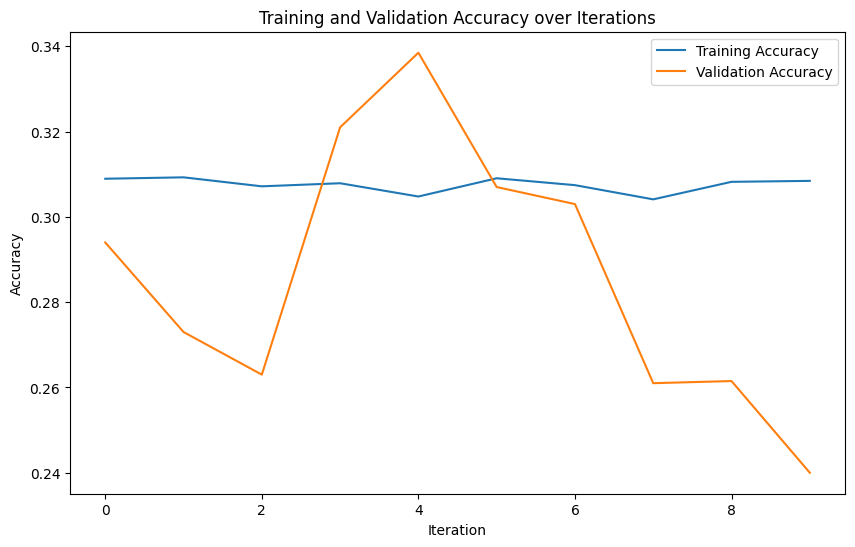

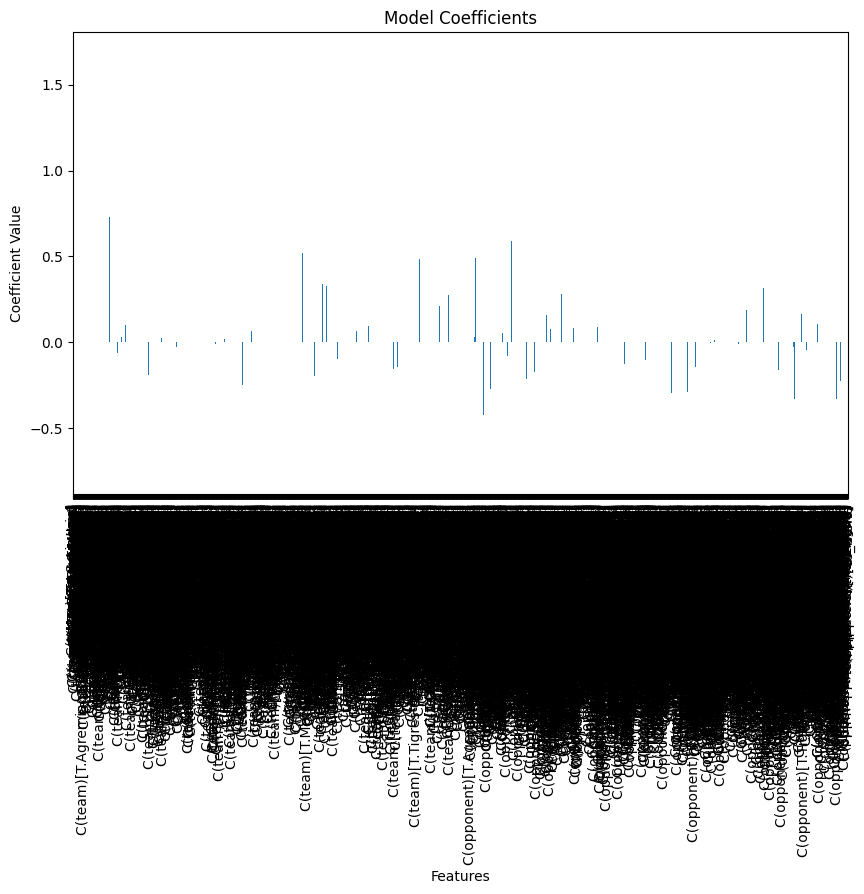

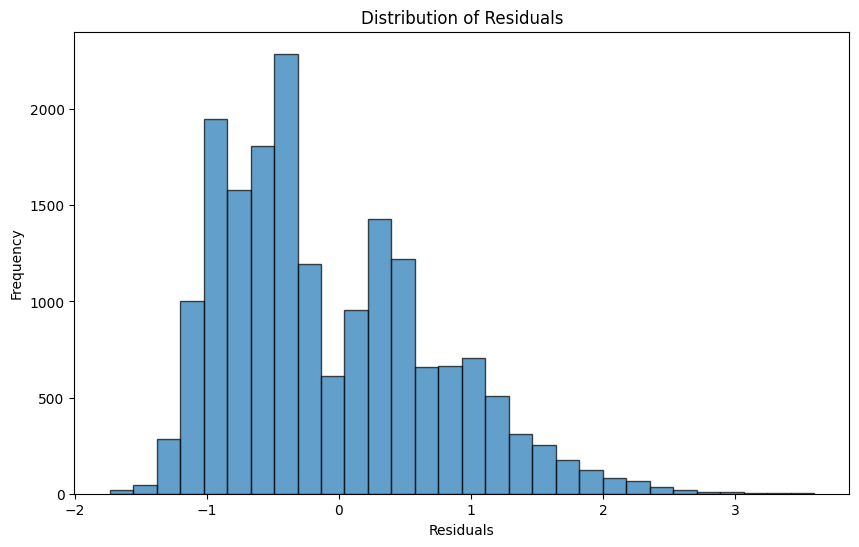

Model Accuracy on Test Set: 0.45478777109163604
         Date    Sea   Lge         HT          AT   HS   AS  Lambda_HS  \
0  09/11/2013  13-14  GER1  Wolfsburg    Dortmund  2.0  1.0          2   
1  25/02/2012  11-12  GER1  Wolfsburg  Hoffenheim  1.0  2.0          2   
2  02/02/2013  12-13  GER1  Wolfsburg    Augsburg  1.0  1.0          2   
3  21/01/2012  11-12  GER1  Wolfsburg     FC Koln  1.0  0.5          2   
4  28/01/2017  16-17  GER1  Wolfsburg    Augsburg  1.0  2.0          2   

   Lambda_AS  prob_home_win  prob_away_win  prob_draw predicted_outcome  \
0          2       0.341458       0.427210   0.231315          away_win   
1          1       0.512592       0.268222   0.219144          home_win   
2          1       0.529150       0.240994   0.229835          home_win   
3          1       0.584598       0.198465   0.216898          home_win   
4          1       0.529150       0.240994   0.229835          home_win   

  actual_outcome  
0       home_win  
1       away_win  

In [9]:
main()